In [1]:
from typing import ContextManager
from astropy.io.fits import hdu
from Spectra import *
from SpectraData import *
from Inventory import *
import matplotlib.pyplot as plt
from astropy.io import fits
import pandas as pd
import sys, os
import numpy as np
from rescaleSky import *
import glob 
from mergeExpositions import *
from HighSeeing import HighSeeing_Filter
import warnings
from astropy.stats import sigma_clip
import seaborn as sns
from Tools import *
import pandas
import pandas
import math
import scipy.special as scispe
warnings.filterwarnings('ignore')

print(os.getcwd())

/Users/gonzalo/Desktop/Code/Gonzalo_Binospec/A-Project/B-CalibrationCode


In [2]:
al=np.load("Alldist.npy",allow_pickle=True)

In [3]:
data_dir = 'data/'
#slits = pd.read_csv(data_dir+'BLAS_1_slits.csv')


fname_data1 = np.sort(glob.glob(data_dir+"large_files/Raw/mask2/Expositions/mask1/*/*_abs_slits_lin_fluxcal_telcor.fits"))
fname_err1  = np.sort(glob.glob(data_dir+"large_files/Raw/mask2/Expositions/mask1/*/*_abs_err_slits_lin_fluxcal_telcor.fits"))
fname_data2 = np.sort(glob.glob(data_dir+"large_files/Raw/mask2/Expositions/mask2_1/*/*_abs_slits_lin_fluxcal_telcor.fits"))
fname_err2  = np.sort(glob.glob(data_dir+"large_files/Raw/mask2/Expositions/mask2_1/*/*_abs_err_slits_lin_fluxcal_telcor.fits"))
fname_data3 = np.sort(glob.glob(data_dir+"large_files/Raw/mask2/Expositions/mask2_2/*/*_abs_slits_lin_fluxcal_telcor.fits"))
fname_err3  = np.sort(glob.glob(data_dir+"large_files/Raw/mask2/Expositions/mask2_2/*/*_abs_err_slits_lin_fluxcal_telcor.fits"))
fname_data4 = np.sort(glob.glob(data_dir+"large_files/Raw/mask2/Expositions/mask2_3/*/*_abs_slits_lin_fluxcal_telcor.fits"))
fname_err4  = np.sort(glob.glob(data_dir+"large_files/Raw/mask2/Expositions/mask2_3/*/*_abs_err_slits_lin_fluxcal_telcor.fits"))


def Reduction(fname_data,fname_err,mask_name,SCALEs=None):
    EXP_data=[] # this should have size galxy number * exp number
    EXP_times=[] # this should have size galaxy number * exp number
    EXP_errs=[]
    Ypix=[]
    MasknonDetect    =   nonDetections_everything(pandas.read_csv('../Docs/'+mask_name+'.csv',sep=";"))

    contar=0
    for data,err in zip(fname_data[:],fname_err[:]):
        print(contar, data)
        if HighSeeing_Filter(data,mask_name) == False:
            print(data,": Skipped")
            continue

        hdu_list_flux = fits.open(data)
        hdu_list_err = fits.open(err)

        Specs=[]

        expositions=[]
        expositions_errors=[]
        exposition_times=[]
        ypix=[]


        for i in range(0,len(hdu_list_flux)): # only for a couple, not len(hdu_list_flux)
            if "ImageHDU" in str(hdu_list_flux[i]): # WE ONLY GRAB ImageHDU 's
                flux=hdu_list_flux[i]
                error=hdu_list_err[i]
                Inventory(Spectra(flux,SpectraData(flux,error))).addSpectra(Specs,flux) #Spectra object needs ID,RA,DEC,Z & SpectraData object where we put our spectra
            
        

        Skies=[]
        for s in np.array(Specs)[MasknonDetect]: 
            Skies.append(s.Data.skySpectra())
        SSpectra=np.nanmedian(Skies,axis=0)

        for s in Specs:
            exposition_times.append(s.expTime)
            ypix.append(s.Ypix)
            sScale=None
            if "HST" in s.Data.header["SLITOBJ"]:
                sScale=SCALEs[contar]
            
            if mask_name in ["Mask1"]:
                s.Data.processSlit(SSpectra,skyscale=sScale)
            dat = s.Data.rawData
            err = s.Data.error
            
            expositions.append(dat)
            expositions_errors.append(err)

        contar+=1
        hdu_list_flux.close()
        hdu_list_err.close()    
        

        EXP_data.append(expositions)
        EXP_errs.append(expositions_errors)
        EXP_times.append(exposition_times)
        Ypix.append(ypix)



    D=np.transpose(EXP_data,axes=[1,0])
    E=np.transpose(EXP_errs,axes=[1,0])
    T=np.transpose(EXP_times)
    Y=np.transpose(Ypix)


    for i in range(0,len(Specs)):
        s=Specs[i]
        d,e,y=mergeExpositions(D[i],E[i],T[i],Y[i])
        s.Data.save2fitsNew(d,e,y,folder=data_dir+"large_files/Reduced_Data/"+mask_name+"/2D/")

    return





###
# Get Noise so sigma(S/N) = 1
###







In [4]:
MinProps_1=np.load("../A-Catalogs/files/MinimizationData_mask1.npy",allow_pickle=True)
MinProps_2=np.load("../A-Catalogs/files/MinimizationData_mask2.npy",allow_pickle=True)
MinProps_3=np.load("../A-Catalogs/files/MinimizationData_mask3.npy",allow_pickle=True)
MinProps_4=np.load("../A-Catalogs/files/MinimizationData_mask4.npy",allow_pickle=True)

A_1,A_2,A_3,A_4 =   np.median(np.transpose(MinProps_1)[0],axis=0),np.median(np.transpose(MinProps_2)[0],axis=0),np.median(np.transpose(MinProps_3)[0],axis=0),np.median(np.transpose(MinProps_4)[0],axis=0)


FileNotFoundError: [Errno 2] No such file or directory: '../A-Catalogs/files/MinimizationData_mask1.npy'

#  FIX NOISE
## Noise is overestimated..

In [5]:
def FixNoise(mask_name):
    Specs = readALLData("large_files/Reduced_Data/"+mask_name+"/2D/*.fits")
    NoiseScales=ScaleNoise(mask_name)
    print(NoiseScales)
    for i in range(0,len(Specs)):
        s=Specs[i]
        s.Data.save2fitsNew(s.Data.rawData,s.Data.error*float(NoiseScales[s.Data.header["SIDE"]]),s.Ypix,folder=data_dir+"large_files/Reduced_Data/"+mask_name+"/2D/noiseCorrected/")
    NoiseScales=ScaleNoise(mask_name,version="noiseCorrected")
    print(NoiseScales)
    return




def FillwithNoise(mask_name):
    Specs = readALLData("large_files/Reduced_Data/"+mask_name+"/2D/noiseCorrected/*.fits")
    for d in Specs[:]:
        d.Data.rawData[d.Data.rawData == 0] = np.nan
        mean=np.nanmean(d.Data.rawData)/100
        std=np.nanstd(d.Data.rawData)/100
        for i in range(0,len(d.Data.rawData)):
            for j in range(0,len(d.Data.rawData[0])):
                if np.isnan(d.Data.rawData[i][j])==True: 
                    d.Data.rawData[i][j]=np.random.normal(mean,std,1)[0]
        
        d.Data.save2fitsNew(d.Data.rawData,d.Data.error,d.Ypix,folder=data_dir+"large_files/Reduced_Data/"+mask_name+"/2D/RandomNoise/")








In [6]:
DO_LINESELECTION=False

width = 5 #width of the region that we will extract around Ypos
SNRthresh = 2. #SNR threshold
PIXthresh= 2 #number of pixels above SNRthresh that are together
ypos = "x" #This is given in header, header value is not 100% accurate
scanArea= 5 # area that we are scanning above and below the centra ypos, this way we dont care about the accuracy of the source position


data_dir = '../A-Catalogs/data/'
fname_data = np.sort(glob.glob(data_dir+"large_files/Reduced_Data/Mask2_2/2D/noiseCorrected/*.fits")) #read data
fname_data = [i for i in fname_data if "3DHST" not in i and "f_" not in i] #takes only LAEs
PossibleLines=[]
Specs=[]
for data in fname_data[:]:
    HDU = fits.open(data)
    flux=HDU[0]
    error=HDU[1]
    Inventory(Spectra(flux,SpectraData(flux,error))).addSpectra(Specs,flux)  #This is the class that has many functions to manipulate the data


if DO_LINESELECTION==True: 
    
    for s in Specs[:]:
        lineData={}
        lineData["ID"]=s.ID
        print(s.ID)
        originalY=int(np.round(s.Ypix)) 
        deltaY=int(np.round(width/2)) 

        foundCandidates=[]
        for y in np.arange(-scanArea,scanArea+1):
            d,e=s.Data.collapse(ywidth=width,YPIX=originalY+y)
            SNR=d/e
            consecutiveSigmas=0

            for i in range(0,len(SNR)): #This part starts counting when SNR and PIX threshs are met

                if SNR[i]>=SNRthresh:
                    consecutiveSigmas+=1
                    

                elif consecutiveSigmas==3:
                    foundCandidates.append((i-1,originalY+y))
                    consecutiveSigmas=0

                else:
                    consecutiveSigmas=0

        file1 = open(data_dir+"large_files/Reduced_Data/Mask2_2/2D/regions/"+str(s.ID)+".reg", "w") #Here it just outs everything into ds9.reg format
        file1.writelines("# Region file format: DS9 version 4.1 \n")
        file1.writelines("global color=green dashlist=8 3 width=1 font=\"helvetica 10 normal roman\" select=1 highlite=1 dash=0 fixed=0 edit=1 move=1 delete=1 include=1 source=1 \n")
        file1.writelines("image \n")
        [file1.writelines( "circle("+str(i[0])+","+str(i[1])+","+"10.0) \n")  for i in foundCandidates]
        file1.close()

            #print()
            #plt.plot(SNR)
            #plt.plot(3.0*e)
            #plt.xlim(2080,2130)
            #plt.ylim(-1e-21,3e-21)
            #plt.show()
        lineData["Candidates"]=foundCandidates 
        PossibleLines.append(lineData) #save positions
    

In [7]:
def read_Catalogs(df):
    """"
    Reads the catalogs with the wavelength and Ypos
    that I eye searched before

    df : csv file
    
    returns:
    coords: Y position and wavelegnth of emission line
    """
    mascara=[]
    for name in df["name"].values:
        if "HST" not in name and "f_" not in name:
            mascara.append(True)
        else: 
            mascara.append(False)
    df=df[mascara]
    coords=[]
    for i in df["coord"].values:
        if "," in i:
            d=i.split(",")
        elif "_" in i:
            d=i.split("_")
        else:
            d="X"
        try:
            if float(d[0])/1000.0>1:
                coords.append([float(d[1]),float(d[0])])
            elif float(d[0])/1000.0<1:
                coords.append([float(d[0]),float(d[1])])

        except:
            coords.append([np.nan,np.nan])

    
    return coords


def readData(location):
    data_dir = '../A-Catalogs/data/'
    fname_data = np.sort(glob.glob(data_dir+location)) #read data
    fname_data = [i for i in fname_data if "3DHST" not in i and "f_" not in i] #takes only LAEs
    Specs=[]
    for data in fname_data[:]:
        HDU = fits.open(data)
        flux=HDU[0]
        error=HDU[1]
        Inventory(Spectra(flux,SpectraData(flux,error))).addSpectra(Specs,flux)  #This is the class that has many functions to manipulate the data
    return Specs


coords1=read_Catalogs(pandas.read_csv('../../Docs/Mask1.csv',sep=";"))
coords2=read_Catalogs(pandas.read_csv('../../Docs/Mask2_1.csv',sep=";"))
coords3=read_Catalogs(pandas.read_csv('../../Docs/Mask2_2.csv',sep=";"))
coords4=read_Catalogs(pandas.read_csv('../../Docs/Mask2_3.csv',sep=";"))
coords=coords1+coords2+coords3+coords4

Specs1=readData("large_files/Reduced_Data/Mask1/2D/noiseCorrected/*.fits")
Specs2=readData("large_files/Reduced_Data/Mask2_1/2D/noiseCorrected/*.fits")
Specs3=readData("large_files/Reduced_Data/Mask2_2/2D/noiseCorrected/*.fits")
Specs4=readData("large_files/Reduced_Data/Mask2_3/2D/noiseCorrected/*.fits")
Specs=Specs1+Specs2+Specs3+Specs4
print(np.shape(Specs3))

wave=np.arange(6760.0,6760.0+5631*0.620000004768,0.620000004768)

# define models






eks=50
counter=1
ALL=[]
Export={}
for s,c in zip(Specs,coords):
    yp=c[0]
    #print(yp)
    if np.isnan(yp)==False:
        #print(counter)
        ekslim=c[1]
        minimask=(wave>ekslim-eks) & (wave<ekslim+eks+eks)
        d,e=s.Data.collapse(ywidth=7,YPIX=yp)
        #print(c)
        #wave1=angstromTokms(c[1],wave)
        #plt.plot(wave[minimask],d[minimask])
        #plt.plot(wave[minimask],e[minimask],alpha=0.5)
        #plt.plot(wave[minimask],3*e[minimask],"--",alpha=0.5)
        ALL.append((wave[minimask],d[minimask],e[minimask],c[1],s.ID,s.Data.rawData,s.Ra,s.Dec,s.Data.error))
        Export[s.ID]=[wave,d,e]
        #print(np.sum(d[minimask]))
        #plt.title(s.ID)
        #plt.xlim(ekslim-50,ekslim+50)
        #plt.ylim()
        #plt.savefig(data_dir+"profiles/mask1/"+str(counter)+"_"+str(s.ID)+".pdf",dpi=200)
        #plt.show()
        counter+=1


print(len(Specs),len(coords),np.shape(ALL))


(74,)
322 322 (90, 9)


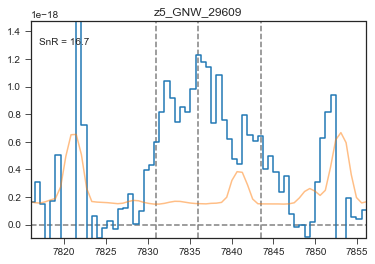

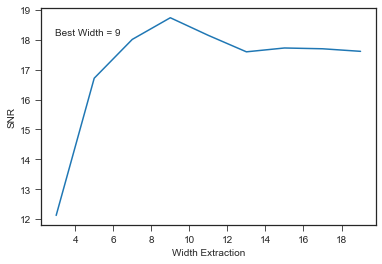

In [8]:
for s,c in zip(Specs,coords):
    yp=c[0]
    #print(yp)
    widths=np.arange(3,20,2)
    if np.isnan(yp)==False and s.ID=="z5_GNW_29609":
        SN=[]
        for ext_width in widths:
            ekslim=c[1]
            minimask=(wave>ekslim-eks) & (wave<ekslim+eks+eks)

        

            d,e=s.Data.collapse(ywidth=ext_width,YPIX=yp)
            spec_width_L=10
            spec_width_R=15.
            spec_mask=(wave>ekslim-spec_width_L) & (wave<ekslim+spec_width_R)
            Signal=np.sum(d[spec_mask])
            Noise=np.sqrt(np.sum(e[spec_mask]**2))
            SN.append(Signal/Noise)
            center=ekslim
            if ext_width==5:
                f, ax = plt.subplots()
                plt.axvline(x=center,ls="--",color="gray")

                plt.axvline(x=center-spec_width_L/2,ls="--",color="gray")
                plt.axvline(x=center+spec_width_R/2,ls="--",color="gray")
                plt.axhline(y=0,color="gray",ls="--")



                plt.text(0.1, 0.9, 'SnR = '+str(np.round(Signal/Noise,1)),
                    horizontalalignment='center',
                    verticalalignment='center',
                    transform = ax.transAxes)
                plt.step(wave[minimask],d[minimask])
                plt.plot(wave[minimask],e[minimask],alpha=0.5)
                plt.title(s.ID)
                plt.xlim(ekslim-20,ekslim+20)
                plt.ylim(-0.1e-18,max(d[spec_mask])*1.2)
                plt.show()
                #plt.clf()
            

plt.plot(widths,SN)
plt.text(0.1, 0.9, 'Best Width = '+str(widths[SN.index(max(SN))]),
    horizontalalignment='center',
    verticalalignment='center',
    transform = ax.transAxes)
plt.xlabel("Width Extraction")
plt.ylabel("SNR")
plt.show()


In [9]:
import emcee
import corner
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize


##### MCMC


def skewed_gaussian(x,flux, mu, FWHM,g,C) :
    """Gaussian"""
    d=np.power(10,g)/(np.sqrt(1+(np.power(10,g))**2))
    fw_param=(FWHM/(2*np.sqrt(2*np.log(2)))/np.sqrt((1-(2*d**2/np.pi))))
    return (flux/(fw_param*np.sqrt(2*np.pi))) * np.exp( -0.5 * (x-mu)**2 / fw_param**2)* (1+scispe.erf( (10**g)*(x-mu)/(fw_param*np.sqrt(2)))) +C


def Double_skewed_gaussian(x,flux1, mu1, FWHM1,g1,flux2, mu2, FWHM2,g2,C) :
    """Gaussian"""
    d1=10**g1/(np.sqrt(1+(np.power(10,g1))**2))
    d2=10**g2/(np.sqrt(1+(np.power(10,g2))**2))
    fw_param1=(FWHM1/(2*np.sqrt(2*np.log(2)))/np.sqrt((1-(2*d1**2/np.pi))))
    fw_param2=(FWHM2/(2*np.sqrt(2*np.log(2)))/np.sqrt((1-(2*d2**2/np.pi))))
    return (flux1/(fw_param1*np.sqrt(2*np.pi))) * np.exp( -0.5 * (x-mu1)**2 / fw_param1**2)* (1+scispe.erf( (10**g1)*(x-mu1)/(fw_param1*np.sqrt(2)))) + (flux2/(fw_param2*np.sqrt(2*np.pi))) * np.exp( -0.5 * (x-mu2)**2 / fw_param2**2)* (1+scispe.erf( (10**g2)*(x-mu2)/(fw_param2*np.sqrt(2)))) + C


def log_prior(theta,meanL,meanG):
    flux, mu,FWHM,g,C = theta
    if 0 < flux < 10. and 0. < FWHM < 30. and np.log10(0.1) < g < np.log10(15)  and -1 < C < 1: #way to get the ranges and define as finite when they are inside the ranges
        return 0.0 
    return -np.inf

def Double_log_prior(theta,meanL,meanG):
    flux1, mu1,FWHM1,g1,flux2,mu2,FWHM2,g2,C = theta
    if 0 < flux1 < 10. and 0. < FWHM1 < 30. and np.log10(0.1) < g1 < np.log10(15)  and 0 < flux2 < 10. and 0. < FWHM2 < 30. and np.log10(0.1) < g2 < np.log10(15) and -1 < C < 1: #way to get the ranges and define as finite when they are inside the ranges
        return 0.0 
    return -np.inf


def log_likelihood(theta, x, y, yerr):
    flux, mu,FWHM,g,C = theta
    model = skewed_gaussian(x,flux, mu,FWHM,g,C)
    sigma2 = yerr ** 2  #sigma2 is sigma square from the likelihood stuff, not the gaussian
    return -0.5 * np.sum((y - model) ** 2 / sigma2 + np.log(sigma2))

def Double_log_likelihood(theta, x, y, yerr):
    flux1, mu1,FWHM1,g1,flux2, mu2,FWHM2,g2,C = theta
    model = Double_skewed_gaussian(x,flux1, mu1,FWHM1,g1,flux2, mu2,FWHM2,g2,C)
    sigma2 = yerr ** 2  #sigma2 is sigma square from the likelihood stuff, not the gaussian
    return -0.5 * np.sum((y - model) ** 2 / sigma2 + np.log(sigma2))

def log_probability(theta, x, y, yerr,meanL,meanG):
    lp = log_prior(theta,meanL,meanG)
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_likelihood(theta, x, y, yerr)


##### ML


def skewed_gaussian_ML(x,flux, mu, FWHM,g,C) :
    """Gaussian"""
    d=g/(np.sqrt(1+g**2))
    fw_param=(FWHM/(2*np.sqrt(2*np.log(2)))/np.sqrt((1-(2*d**2/np.pi))))
    return (flux/(fw_param*np.sqrt(2*np.pi))) * np.exp( -0.5 * (x-mu)**2 / fw_param**2)* (1+scispe.erf( g*(x-mu)/(fw_param*np.sqrt(2)))) + C


def Double_skewed_gaussian_ML(x,flux1, mu1, FWHM1,g1,flux2, mu2, FWHM2,g2,C) :
    """Gaussian"""
    d1=g1/(np.sqrt(1+g1**2))
    d2=g2/(np.sqrt(1+g2**2))
    fw_param1=(FWHM1/(2*np.sqrt(2*np.log(2)))/np.sqrt((1-(2*d1**2/np.pi))))
    fw_param2=(FWHM2/(2*np.sqrt(2*np.log(2)))/np.sqrt((1-(2*d2**2/np.pi))))
    return (flux1/(fw_param1*np.sqrt(2*np.pi))) * np.exp( -0.5 * (x-mu1)**2 / fw_param1**2)* (1+scispe.erf( g1*(x-mu1)/(fw_param1*np.sqrt(2)))) + (flux2/(fw_param2*np.sqrt(2*np.pi))) * np.exp( -0.5 * (x-mu2)**2 / fw_param2**2)* (1+scispe.erf( g2*(x-mu2)/(fw_param2*np.sqrt(2)))) + C


def log_prior_ML(theta,meanL,meanG):
    flux, mu,FWHM,g,C = theta
    if 0 < flux < 10. and 0. < FWHM < 30. and 0 < g < 15  and -1 < C < 1: #way to get the ranges and define as finite when they are inside the ranges
        return 0.0 
    return -np.inf

def Double_log_prior_ML(theta,meanL,meanG):
    flux1, mu1,FWHM1,g1,flux2,mu2,FWHM2,g2,C = theta
    if 0 < flux1 < 10. and 0. < FWHM1 < 30. and 0. < g1 < 15  and 0 < flux2 < 10. and 0. < FWHM2 < 30. and 0 < g2 < 30 and -1 < C < 1: #way to get the ranges and define as finite when they are inside the ranges
        return 0.0 
    return -np.inf


def log_likelihood_ML(theta, x, y, yerr):
    flux, mu,FWHM,g,C = theta
    model = skewed_gaussian_ML(x,flux, mu,FWHM,g,C)
    sigma2 = yerr ** 2  #sigma2 is sigma square from the likelihood stuff, not the gaussian
    return -0.5 * np.sum((y - model) ** 2 / sigma2 + np.log(sigma2))

def Double_log_likelihood_ML(theta, x, y, yerr):
    flux1, mu1,FWHM1,g1,flux2, mu2,FWHM2,g2,C = theta
    model = Double_skewed_gaussian_ML(x,flux1, mu1,FWHM1,g1,flux2, mu2,FWHM2,g2,C)
    sigma2 = yerr ** 2  #sigma2 is sigma square from the likelihood stuff, not the gaussian
    return -0.5 * np.sum((y - model) ** 2 / sigma2 + np.log(sigma2))

def log_probability_ML(theta, x, y, yerr,meanL,meanG):
    lp = log_prior_ML(theta,meanL,meanG)
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_likelihood_ML(theta, x, y, yerr)

#sigma to FWHM, amp to flux and g to skewness







walkers=30
Flux=(0.05 * np.random.randn(walkers, 1))
Mean=(0.5 * np.random.randn(walkers, 1))
fwhm=(0.2 * np.random.randn(walkers, 1))
g=(0.1 * np.random.randn(walkers, 1))
C=(0.02 * np.random.randn(walkers, 1))

W=[]
for a,m,s,g,c in zip(Flux,Mean,fwhm,g,C):
    W.append([a[0],m[0],s[0],g[0],c[0]])

W2=[]
for a,m,s,g,c in zip(Flux,Mean,fwhm,g,C):
    W2.append([a[0],m[0],s[0],g,a[0],m[0],s[0],g,c[0]])



In [10]:
def angstromTokms(centralA,As):
    c=300000
    v=As*(c/centralA)
    return v

def kmsToangstrom(v,centralA):
    c=300000
    As = centralA*(v+c)/c
    return As

def kmsToangstrom2(v,centralA):
    c=299792
    As = centralA*(v+c)/c
    return np.abs(centralA-As)

def fix_XTicks(ticks,typeOfData):
    if typeOfData=='wave':
        for t in ticks[:-1]:
            if np.abs(ticks[-1]-t)<3:
                ticks=ticks[ticks!=t]
        
        newt=[]
        for t in ticks:
            if t%5==0:
                newt.append(int(t))
            else:
                newt.append(np.round(t,2))

        print(newt)
        return newt

    if typeOfData=='kms':
        for t in ticks[:-1]:
            if np.abs(ticks[-1]-t)<1:
                ticks=ticks[ticks!=t]
        return ticks

def fix_XticksVelocities(cLambda,typeOfData):
    if typeOfData=='kms':
        labels=np.linspace(-1000,1000,11)
        ticks=[]
        for l in labels:
            ticks.append(kmsToangstrom(l,cLambda))

        return ticks,labels.astype(int)

def redshift(Lambda):
    z=(Lambda/1215.3357)-1
    return z

def redshiftToWave(z):
    wave=1215.32*(1+z)
    return wave

def SkewedMean(loc,scale,shape):
    d=shape/(np.sqrt(1+shape**2))
    return loc+scale*d*np.sqrt(2/np.pi)

def skewed_gaussian_simple(x,mu,sigma,g,C) :
    """Gaussian"""
    return np.exp( -0.5 * (x-mu)**2 / sigma**2)* (1+scispe.erf( g*(x-mu)/(sigma*np.sqrt(2)))) + C

def SkewedPeak(loc,fwhm,shape):
    '''
    I plot a skewed gaussian with C=0, and given params.
    Then search for its peak value.
    Use that for zLya
    '''
    peaks=[]
    for i in range(0,len(loc)):
        x=np.arange(loc[i]-500,loc[i]+500,0.01) #range
        d=shape[i]/(np.sqrt(1+shape[i]**2)) #asymmetry score
        sigma=(fwhm[i]/(2*np.sqrt(2*np.log(2)))/np.sqrt((1-(2*d**2/np.pi)))) #std
        
        gausiana=skewed_gaussian_simple(x,loc[i],sigma,shape[i],0.)
        id_peak=np.where(gausiana == max(gausiana))
        peaks.append(x[id_peak][0])
    return np.array(peaks)
    

def SkewedSTD(scale,shape):
    d=shape/(np.sqrt(1+shape**2))
    var=scale**2 * (1-(2*d**2/np.pi))
    return np.sqrt(var)



In [11]:
def SNR(wave,flux,err,gal):
    LyaWave=1215.3357*(1+gal["z"][0])
    FWHM=kmsToangstrom2(gal["LyaFWHM"][0],LyaWave)
    print(gal["LyaFWHM"][0])
    print(LyaWave,FWHM)

    mask=(wave>LyaWave-FWHM/2) & (wave<LyaWave+FWHM/2)
    flux=flux[mask]
    err=err[mask]

    Signal=np.sum(flux)
    Noise=np.sqrt(np.sum(err**2))
    SNR=Signal/Noise
    #print(wave[mask])

    return SNR


  3%|▎         | 58/2000 [00:00<00:03, 576.78it/s]

No exception
normalization 2.6722500967081745e-18
norm 2.6722500967081745e-18
normalization 2.6722500967081745e-18


100%|██████████| 2000/2000 [00:04<00:00, 475.12it/s]


<Figure size 720x504 with 0 Axes>

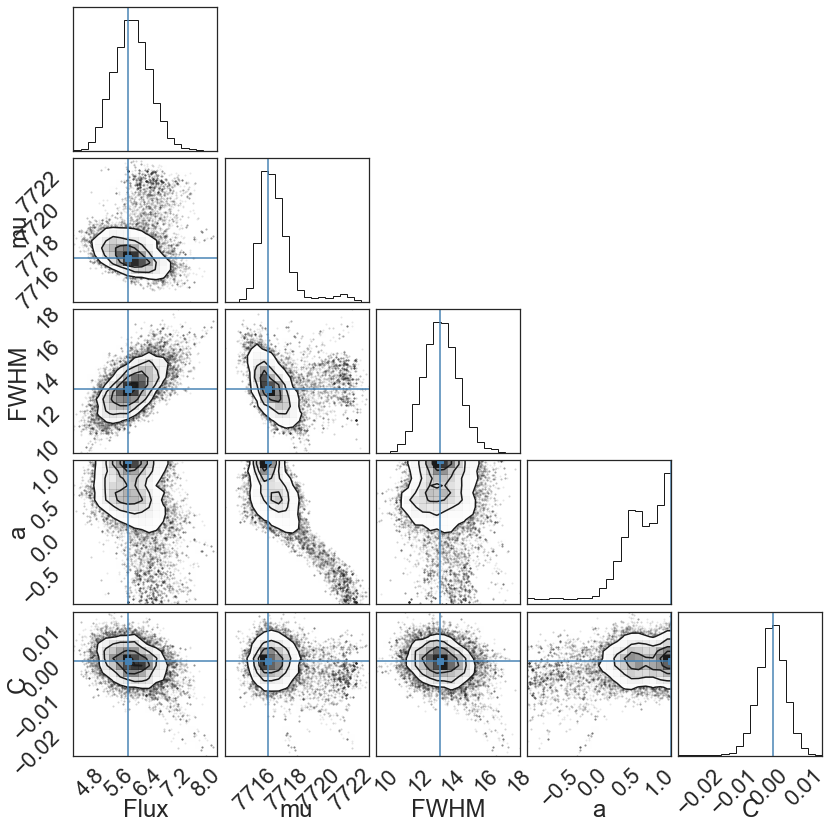

217.6863416660393
7718.614945783347 5.604676076333817
SNR =  7.178894020113276
Offset        voff      
-----------------
258.1571999638276
Offset        voff      
-----------------
6.644105803068669 7721.0
Points 7720.300011386393 7721.0
       voff      
-----------------
7683.655905583324        voff      
-----------------
7743.655905583324


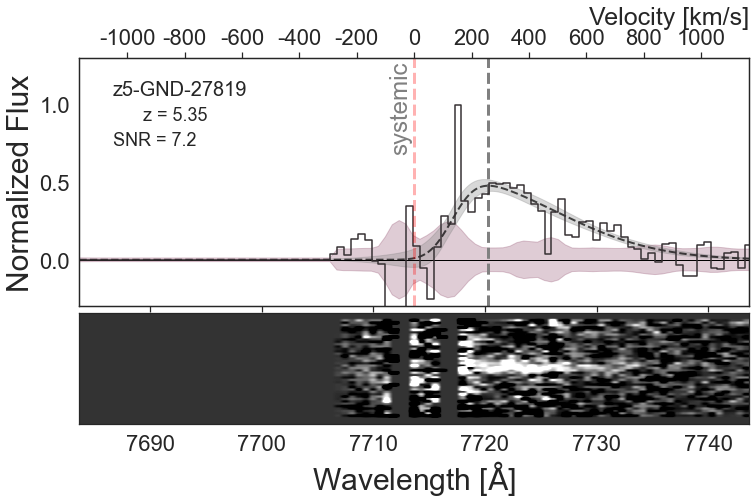

In [14]:
DO_FITTING=True


from scipy.integrate import simps
from scipy import stats
from numpy import trapz
from scipy.stats import sigmaclip
from exception import *
sns.set_theme(style="white",font_scale = 2)
plt.rcParams["figure.figsize"] = (12,8)

def getValues(wave,f,ferr,mx=None):
    x=wave
    if mx==None:
        mx=max(f)
    y=f/mx
    print("normalization",mx)
    yerr=ferr/mx
    original_yerr=ferr/mx
    x0 = np.linspace(min(x), max(x), 5000)
    return x,mx,y,yerr,original_yerr,x0

wave2D=np.arange(6760.0,6760.0+5631*0.620000004768,0.620000004768)

Catalog=ascii.read("../A-Catalogs/Binospec-Candels.cat")
Profile_data=[]
if DO_FITTING==True:
    All_Dist=[]
    Coords=[]
    for A in ALL[:]:

        clambda=A[3]
        ID=A[4]
        if ID!="z5_GND_27819":
            continue
        Ra=A[6]
        Dec=A[7]
        galaxia=Catalog[Catalog["id_charlotte"]==ID]
        if np.isnan(galaxia["voff"])==True:
            continue

        exc = [e  for e in giveExceptions() if e['ID']==A[4]] #Match ID to exception ID
        if exc==[]:
            print("No exception")
            excStatus=False
            eks=20
            mask=(A[0]>clambda-eks) & (A[0]<clambda+eks)


        elif len(exc)!=0:
            exc=exc[0]
            print("Exception",exc)
            excStatus=True
            
            if exc['Skip']==True:
                continue

            elif exc['CW']!=None:
                clambda=exc["CW"]
            mask = (A[0] >= exc['LW']) & (A[0] <= exc['RW'])  #mask with exception


        ORIGINAL_wavelength=A[0]
        ORIGINAL_flux=A[1]
        ORIGINAL_ferr=A[2]

        wave=A[0][mask]
        f=A[1][mask]
        ferr=A[2][mask]
        x,mx,y,yerr,original_yerr,x0 = getValues(wave,f,ferr)
        print("norm",max(f))
        ORIGINAL_x,ORIGINAL_mx,ORIGINAL_y,ORIGINAL_yerr,ORIGINAL_original_yerr,ORIGINAL_x0 = getValues(ORIGINAL_wavelength,ORIGINAL_flux,ORIGINAL_ferr,mx)



        doubles=Double_peaked()

        if str(A[4]) not in doubles:
            nll = lambda *args: -log_likelihood_ML(*args)   #ML fit
            initial = np.array([0, clambda, 10 , 0 , 0])
            soln = minimize(nll, initial, args=(x, y, yerr))
            flux_ml, mu_ml,FWHM_ml,g_ml,C_ml = soln.x
            if g_ml>15:
                g_ml=15
            if g_ml<0.1:
                g_ml=0.1
            ml_params=np.array([flux_ml,mu_ml,FWHM_ml,np.log10(g_ml),C_ml])

            
            pos = ml_params + W
            nwalkers, ndim = pos.shape

            if ID=="z7_GND_8358":
                mask=(x>9499) & (x<9520)
                y[mask]=0.0

            sampler = emcee.EnsembleSampler(
                nwalkers, ndim, log_probability, args=(x, y, yerr,clambda,g_ml)
            )
            sampler.run_mcmc(pos, 2000, progress=True)  #steps
            



            
            fig, axes = plt.subplots(5, figsize=(10, 7), sharex=True)
            samples = sampler.get_chain(discard=750)
            labels = ["Flux", "mu", "FWHM","g","C"]
            for i in range(ndim):
                ax = axes[i]
                ax.plot(samples[:, :, i], "k", alpha=0.3)
                ax.set_xlim(0, len(samples))
                ax.set_ylabel(labels[i])
                ax.yaxis.set_label_coords(-0.1, 0.5)

            axes[-1].set_xlabel("step number - burn in 750 steps")
            plt.clf()
            #plt.show()


            labels = ["Flux", "mu","FWHM","a","C"]
            samples = sampler.get_chain(discard=750,flat=True)
            fig = corner.corner(samples, labels=labels, truths=[flux_ml,mu_ml,FWHM_ml,np.log10(g_ml),C_ml]) #show quartiles?
            #plt.clf()
            plt.show()


            samples=np.transpose(samples)


            ### Calculate S/N

            SN=SNR(ORIGINAL_x,ORIGINAL_y-np.median(samples[4]),ORIGINAL_yerr,galaxia)
            print("SNR = ",SN)
            gausiana=skewed_gaussian(ORIGINAL_x0,*np.median(samples,axis=1))-np.median(samples[4])
            id_peak=np.where(gausiana == max(gausiana))

            fig, (ax1, ax3) = plt.subplots(2, 1, sharex=True)
            ax2 = ax1.twiny()



            print("Offset", galaxia["voff"])
            offset_kms=galaxia["voff"]


            offset_wave=kmsToangstrom(offset_kms,clambda)
            offset_wave=offset_wave-clambda
            if np.isnan(offset_kms):
                offset_wave = 0
            print("Offset",offset_wave,clambda)

            ax1.axvline(x=np.round(ORIGINAL_x0[id_peak],3),ls="--",color="gray",lw=3)

            ax1.text(0.05, 0.65,s=r"SNR = "+str(np.round(SN,1)),transform=ax1.transAxes,fontsize=18)

            m=[A[8]<np.median(A[8])+2*np.std(A[8])][0]
            Flux2D=np.copy(A[5])

            for i in range(0,len(m)):
                for j in range(0,len(m[i])):
                    if m[i][j]==False:
                        Flux2D[i][j]=0.0

            ax3.imshow(Flux2D,extent=[min(wave2D),max(wave2D),-10,10],aspect=0.5,cmap='gray',vmin=-0.5*np.std(Flux2D[5]),vmax=2*np.std(Flux2D[5]))


            gs=[]
            for i,s in enumerate(np.transpose(samples)):
                if i%50==0:
                    gs.append(skewed_gaussian(ORIGINAL_x0,*s)-s[4])
            


            FitAreaSTD=[]
            for point in np.transpose(gs):
                FitAreaSTD.append(np.std(point))
            FitAreaSTD=np.array(FitAreaSTD)

            ax1.fill_between(ORIGINAL_x0, gausiana-FitAreaSTD, gausiana+FitAreaSTD,color="gray",alpha=0.3)

            
            #ax1.plot(ORIGINAL_x0,g,'#630330',lw=3,alpha=0.01)

            ax1.plot(ORIGINAL_x0,gausiana,'black',ls="--",lw=2,alpha=0.7)
            ax1.axhline(y=0,color='black',lw=1)

            ax1.step(ORIGINAL_x,ORIGINAL_y-np.median(samples[4]),color='#342E31',label='Flux')
            ax1.fill_between(ORIGINAL_x,-ORIGINAL_yerr,ORIGINAL_yerr,color='#630330',alpha=0.2,zorder=-10,label='Noise')
            
            #ax2.set_xticks(ax1.get_xticks())
            #ax2.set_xbound(ax1.get_xbound())

            line_peak=ORIGINAL_x0[id_peak][0]
            print("Points",line_peak,clambda)
            ax2.set_xticklabels([ np.round(angstromTokms(ORIGINAL_x0[id_peak],w)[0],2) for w in ax1.get_xticks()])
            ax2.set_xticks(fix_XticksVelocities(line_peak-float(offset_wave),'kms')[0])
            ax2.set_xticklabels(fix_XticksVelocities(line_peak-float(offset_wave),'kms')[1])
            ax1.axvline(x=fix_XticksVelocities(line_peak-float(offset_wave),'kms')[0][5],ls="--",color="red",alpha=0.3,lw=3)
            ax1.text(0.48, 0.8, 'systemic', transform=ax1.transAxes, ha='center', va='center', color='gray', rotation='vertical')
            

            
            ax1.text(  # position text relative to Axes
                            0.095, 0.75, 'z = '+str(np.round(redshift(mu_ml),2)),
                            transform=ax1.transAxes, size=18
            )


            name = str(A[4]).replace("_", "-")
            ax1.text(  # position text relative to Axes
                            0.05, 0.85, str(name),
                            transform=ax1.transAxes, size=20
            )
            
            ax3.set_xlabel(r"Wavelength [$\mathrm{\AA}$]",fontsize=30)
            ax1.set_ylabel("Normalized Flux",fontsize=30)
            ax2.set_xlabel("Velocity [km/s]",loc='right',fontsize=25)
            #ax1.set_title(str(A[4]),fontsize=30,loc='left')
            ax3.set_yticklabels([])
            ax1.set_ylim(-0.3,1.3)
            ax2.set_ylim(-0.3,1.3)
            ax1.set_xlim(line_peak-30-offset_wave,line_peak+30-offset_wave)
            print(line_peak-30-offset_wave,line_peak+30-offset_wave)
            ax2.set_xlim(line_peak-30-offset_wave,line_peak+30-offset_wave)
            #ax1.legend(loc=1,fontsize=20)
            plt.subplots_adjust(wspace=-0.25, hspace=-0.25)
            plt.savefig('../G-Plots/ForPaper/'+str(A[4])+".pdf",dpi=200, bbox_inches = "tight")
            #plt.clf()
            plt.show()

            #save values

            samples[0]=samples[0]*max(f)
            samples[4]=samples[4]*max(f)

            dist_data={}
            dist_data["amp"]=samples[0]
            dist_data["loc"]=samples[1]
            dist_data["fwhm"]=samples[2]#/(2*np.sqrt(2*np.log(2)))
            dist_data["g"]=samples[3]
            dist_data["C"]=samples[4]
            dist_data["peak"]=ORIGINAL_x0[id_peak][0]


            ML_data={}
            
            ML_data["amp"]=flux_ml
            ML_data["loc"]=mu_ml
            ML_data["fwhm"]=FWHM_ml#/(2*np.sqrt(2*np.log(2)))
            ML_data["g"]=g_ml
            ML_data["C"]=C_ml

            Name={}
            Name["ID"]= str(A[4])

            
            All_Dist.append([dist_data,ML_data,Name])
            Coords.append([ID,Ra,Dec])
            Profile_data.append([str(A[4]),ORIGINAL_x,ORIGINAL_y-np.median(samples[4])])
np.save("Alldist_25JulTest.npy",All_Dist)


In [ ]:
plt.rcParams["figure.figsize"] = (7,3)
plt.hist(10**All_Dist[0][0]["g"])
plt.show()
def MedianHist(vals,bins):
    bin_centers=[(bins[i]+bins[i+1])/2 for i in range(0,len(bins[:-1]))]
    allVals=[]
    counter=0
    for val in vals:
        for i in range(0,val):
            allVals.append(bin_centers[counter])
        counter+=1

    return np.array([np.percentile(allVals,50),np.mean([np.percentile(allVals,50)-np.percentile(allVals,16),np.percentile(allVals,84)-np.percentile(allVals,50)])])
    
def recover_param(data,key):
    ml=[]
    mcmc=[]
    for d in data:
        ml.append(d[1][key])
        try:
            val,bin = np.histogram(d[0][key],bins=100)
            index = np.where(val == max(val)) #Put median
            print(bin[index[0][0]])
            mcmc.append(bin[index[0][0]])
            
        except:
            mcmc.append(np.nan)
        '''
        Make something for gaussian PDFs, and non gaussian PDfs
        fit a gaussian to see if it is gaussian or it isnt
        '''
    return np.array(ml),10**np.array(mcmc)

def skewness_func(g):
    delta=g/(np.sqrt(1+g**2))
    skewness = ((4-np.pi)/2)  * (delta*np.sqrt(2/np.pi)**3)/(1-2*delta**2/np.pi)**(3/2)
    return skewness


print(np.shape(All_Dist))

gs_ml,gs_mcmc=recover_param(All_Dist,"g")
print(gs_mcmc)
#mask=(gs_ml<20) & (gs_ml>-20)

sns.set_theme(style="white",font_scale = 1.2)

binaje=8
kws = dict( linewidth = 3,edgecolor="#342E31",color='#630330',alpha=0.7)
#plt.hist(gs_ml,range=[0,15],bins=binaje,label='ML Results',alpha=0.4,color="#342E31")
plt.hist(gs_mcmc,range=[0,15],bins=binaje,label='MCMC Results',**kws)
print(np.sort(gs_mcmc))
plt.xlabel(r"Asymmetry [$\alpha$]",size=18)
plt.legend()
plt.show()

binaje=8
plt.hist(skewness_func(gs_mcmc),range=[-0.1,1.1],bins=binaje,label='MCMC Results',**kws)
plt.xlabel("Skewness",size=18)
plt.legend()
plt.tight_layout()
#plt.savefig('plots/profiles/Transparent/skewness.png',dpi=200,transparent=True)
            
plt.show()
print(skewness_func(gs_mcmc))



plt.plot([-1000,1000],[-1000,1000],'--',lw=3,color="black",alpha=0.3)
plt.scatter(gs_ml,gs_mcmc)
plt.xlim(-2,18)
plt.ylim(-2,18)
plt.xlabel("Max Likelihood",size=20)
plt.ylabel("MCMC",size=20)
plt.title(r"Asymmetry parameter [$\alpha$]",size=20)
#plt.savefig('plots/profiles/Transparent/skewness.png',dpi=200,transparent=True)
            
plt.show()





fig, ax1 = plt.subplots()
left, bottom, width, height = [0.25, 0.6, 0.2, 0.2]
ax2 = fig.add_axes([left, bottom, width, height])



ax1.plot([-1000,1000],[-1000,1000],'--',lw=3,color="black",alpha=0.3)
ax1.scatter(skewness_func(gs_mcmc),skewness_func(gs_ml))
ax1.set_xlim(-0.2,1.2)
ax1.set_ylim(-0.2,1.2)
ax1.set_ylabel("Max Likelihood",size=20)
ax1.set_xlabel("MCMC",size=20)
ax1.set_title("Skewness",size=20)

ax2.plot([-1000,1000],[-1000,1000],'--',lw=1.5,color="black",alpha=0.3)
ax2.scatter(skewness_func(gs_mcmc),skewness_func(gs_ml),s=15)
ax2.set_xlim(0.9,1)
ax2.set_ylim(0.9,1)


plt.show()

In [ ]:
def recover_param(data,key):
    ml=[]
    mcmc=[]
    for d in data:
        ml.append([d[1][key],np.nan])
        try:
            val,bin = np.histogram(d[0][key],bins=100,range=[d[1][key]-10,d[1][key]+10])

            #plt.plot(bin[:-1],val)
            #plt.axvline(x=MedianHist(val,bin),color="gray",label="median")
            index = np.where(val == max(val)) #Put median
            #plt.axvline(x=bin[index[0][0]],color="red",label="max")
            #plt.legend()
            #plt.title(str(key))
            #plt.clf()
            #plt.show()
            mcmc.append(MedianHist(val,bin))
        except:
            mcmc.append([np.nan,np.nan])
        '''
        Make something for gaussian PDFs, and non gaussian PDfs
        fit a gaussian to see if it is gaussian or it isnt
        '''
        
    return np.array(ml),np.array(mcmc)

def onlyCentralValue(data):
    return np.array([i[0] for i in data])

def only1sigma(data):
    return np.array([i[1] for i in data])

def SkewedPeak(loc,fwhm,shape):
    '''
    I plot a skewed gaussian with C=0, and given params.
    Then search for its peak value.
    Use that for zLya
    '''
    peaks=[]
    for i in range(0,len(loc)):
        x=np.arange(loc[i]-500,loc[i]+500,0.01) #range
        d=shape[i]/(np.sqrt(1+shape[i]**2)) #asymmetry score
        sigma=(fwhm[i]/(2*np.sqrt(2*np.log(2)))/np.sqrt((1-(2*d**2/np.pi)))) #std
        
        gausiana=skewed_gaussian_simple(x,loc[i],sigma,shape[i],0.)
        id_peak=np.where(gausiana == max(gausiana))
        print(id_peak)
        peaks.append(x[id_peak][0])
    return np.array(peaks)
    






def SkewedSTD(scale,shape):
    d=shape/(np.sqrt(1+shape**2))
    var=scale**2 * (1-(2*d**2/np.pi))
    return np.sqrt(var)


ml_loc,mcmc_loc=recover_param(All_Dist,"loc")
ml_fwhm,mcmc_fwhm=recover_param(All_Dist,"fwhm")
gs_ml,gs_mcmc=recover_param(All_Dist,"g")




#gs_ml,gs_mcmc

#ml_mu=SkewedMean(ml_loc,ml_scale,gs_ml)

mcmc_loc=onlyCentralValue(mcmc_loc)
mcmc_fwhm=onlyCentralValue(mcmc_fwhm)
gs_mcmc=onlyCentralValue(gs_mcmc)
ml_loc=onlyCentralValue(ml_loc)
ml_fwhm=onlyCentralValue(ml_fwhm)
gs_ml=onlyCentralValue(gs_ml)

mcmc_mu=SkewedMean(mcmc_loc,mcmc_fwhm,gs_mcmc)
mcmc_peak=SkewedPeak(mcmc_loc,mcmc_fwhm,gs_mcmc) # This for redshifts
ml_peak=SkewedPeak(ml_loc,ml_fwhm,gs_ml)
#ml_fwhm=SkewedSTD(ml_scale,gs_ml)
#mcmc_fwhm=SkewedSTD(mcmc_scale,gs_mcmc)



fig, ax1 = plt.subplots()
left, bottom, width, height = [0.65, 0.4, 0.2, 0.2]
#ax2 = fig.add_axes([left, bottom, width, height])


#ax2.plot([-1000,1000],[-1000,1000],'--',lw=1.5,color="black",alpha=0.3)
#ax2.scatter(skewness_func(gs_ml),skewness_func(gs_mcmc),s=15)
#ax2.set_xlim(0.9,1)
#ax2.set_ylim(0.9,1)
#plt.show()

plt.hist(redshift(mcmc_peak),range=[4.9,7.1],bins=15,**kws)
plt.xlabel(r"Redshift$_{Lya}$")
plt.show()


FWHM_kms=angstromTokms(mcmc_peak,mcmc_fwhm)
#np.save("/Users/gonzalo/Desktop/Code/Gonzalo_Binospec/code/files/FWHM.npy",FWHM_kms)


plt.hist(mcmc_fwhm,bins=13,range=[0,26],**kws)
plt.xlabel(r"FWHM$_{Lya}$ [$\AA$]")
plt.show()


plt.rcParams["figure.figsize"] = (7,5)
sns.set_theme(style="white",font_scale = 1.2)
plt.hist(FWHM_kms,range=[0,800],bins=12,**kws)
plt.xlabel(r"FWHM$_{Lya}$ [km/s]",size=20)
plt.tight_layout()
#plt.savefig('plots/profiles/Transparent/fwhm.png',dpi=200,transparent=True)
plt.show()



In [15]:
def skewed_gaussian(x,flux, mu, FWHM,g,C) :
    """Gaussian"""
    d=np.power(10,g)/(np.sqrt(1+(np.power(10,g))**2))
    fw_param=(FWHM/(2*np.sqrt(2*np.log(2)))/np.sqrt((1-(2*d**2/np.pi))))
    return (flux/(fw_param*np.sqrt(2*np.pi))) * np.exp( -0.5 * (x-mu)**2 / fw_param**2)* (1+scispe.erf( (10**g)*(x-mu)/(fw_param*np.sqrt(2)))) +C



def angstromTokms(centralA,As):
    c=300000
    v=As*(c/centralA)
    return v

def kmsToangstrom(v,centralA):
    c=300000
    As = centralA*(v+c)/c
    return As

def kmsToangstrom2(v,centralA):
    c=299792
    As = centralA*(v+c)/c
    return np.abs(centralA-As)

def redshift(Lambda):
    z=(Lambda/1215.3357)-1
    return z

In [ ]:

def FWHM_literature(amp,loc,fwhm,shape,showPlots=False):
    '''
    I plot a skewed gaussian with C=0, and given params.
    Then search for its peak value.
    Use that for zLya
    '''
    mask = np.random.choice([True, False], size=len(loc), p=[0.3, 0.7])
    loc = loc[mask]
    fwhm = fwhm[mask]
    shape = shape[mask]
    amp = amp[mask]
    fwhms=[]
    peak=[]
    for i in range(0,len(loc)):
        x=np.arange(loc[i]-20,loc[i]+20,0.01) #range
        d=shape[i]/(np.sqrt(1+shape[i]**2)) #asymmetry score
        sigma=(fwhm[i]/(2*np.sqrt(2*np.log(2)))/np.sqrt((1-(2*d**2/np.pi)))) #std
        gausiana=skewed_gaussian(x,amp[i],loc[i],sigma,shape[i],0.)


        half_max = max(gausiana) / 2.0
        indices = np.where(gausiana > half_max)[0]
        fwhm_new = x[indices[-1]] - x[indices[0]]

        peak_value = x[np.argmax(gausiana)]
        fwhm_kms = angstromTokms(peak_value, fwhm_new)
        

        z=redshift(peak_value)
        fwhms.append(fwhm_kms)
        peak.append(z)

        if showPlots and i % 1000 == 0:
            plt.title(shape[i])
            plt.plot(x,gausiana)

            plt.axvline(x=peak_value, color='r', linestyle='--', label=f'Peak: {peak_value:.2f}')
            plt.axvline(x=x[indices[-1]], color='b', linestyle='--', label=f'FWHM: {fwhm_new:.2f}')
            plt.axvline(x=x[indices[0]], color='b', linestyle='--')
            plt.xlim(7685,7745)
            plt.ylim(-0.1*max(gausiana),1.5*max(gausiana))
            plt.legend()
            plt.show()
    print("Finished")

    return np.array(fwhms),np.array(peak)
    

In [25]:
Fix_FWHM=False
from decimal import Decimal

if Fix_FWHM==True:
    def lin_equ(l1, l2):
        """Line encoded as l=(x,y)."""
        m = Decimal((l2[1] - l1[1])) / Decimal(l2[0] - l1[0])
        c = (l2[1] - (m * l2[0]))
        return m, c

    def Give_instrumental_Res(wave):
        m,c=lin_equ([5800,40],[10000,20])
        return wave*float(m)+float(c)


    Catalog=ascii.read("../A-Catalogs/Binospec-Candels.cat")
    for gal in Catalog:
        if gal["id_charlotte"]=="Hu10_z7_1":
            gal["dLyaFWHM"]=25


    #Catalog["dLyaFWHM_int"]=EmptyArray
    for gal in Catalog:
        print(gal["id_charlotte"])
        wave=1215.67 *(1+gal["z"])
        inst=Give_instrumental_Res(wave)
        print(inst,wave)
        if gal["LyaFWHM_int"]<=inst:
            gal["LyaFWHM_int"]=inst
            gal["dLyaFWHM_int"]=0

        else:
            new_fw=np.sqrt(gal["LyaFWHM"]**2-inst**2)
            new_fw_plus=np.sqrt((gal["LyaFWHM"]+gal["dLyaFWHM"])**2-inst**2)
            new_fw_minus=np.sqrt((gal["LyaFWHM"]-gal["dLyaFWHM"])**2-inst**2)
            print(new_fw_plus,new_fw_minus)
            new_fw_err= np.nanmean([new_fw_plus-new_fw ,new_fw-new_fw_minus] )
            #print(gal["LyaFWHM"],gal["dLyaFWHM"])
            #print(gal["LyaFWHM_int"],gal["dLyaFWHM_int"])
            print(new_fw,new_fw_err)
            print("   ")
            


        gal["dLyaFWHM_int"]=new_fw_err
        gal["LyaFWHM_int"]=new_fw

    ascii.write(Catalog,"../A-Catalogs/Binospec-Candels.cat",overwrite=True)

z5_GND_27819


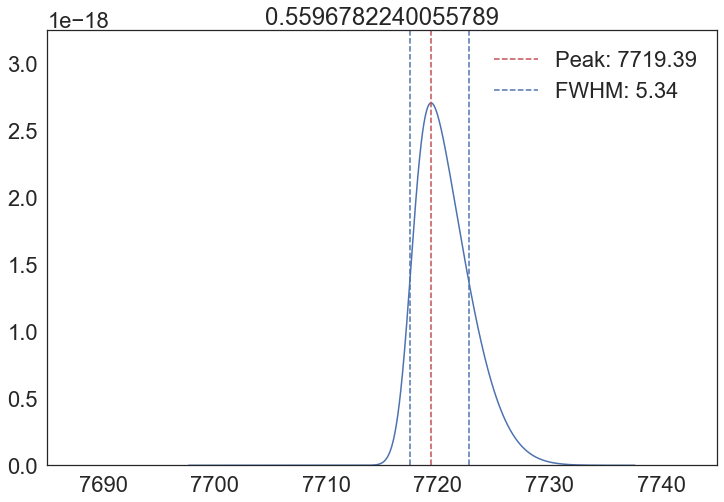

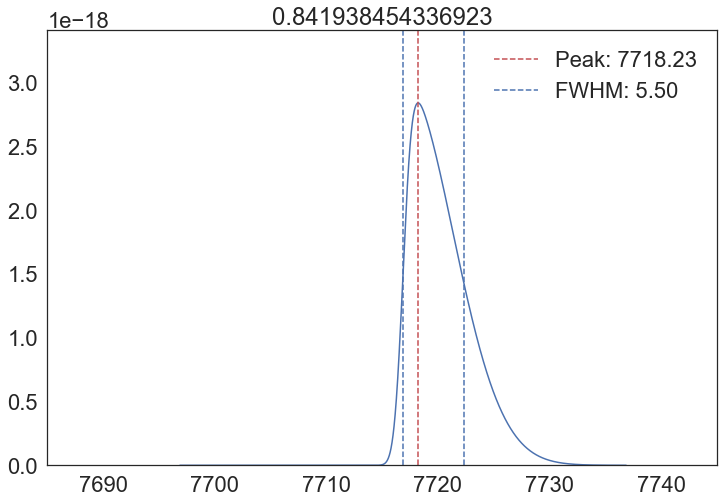

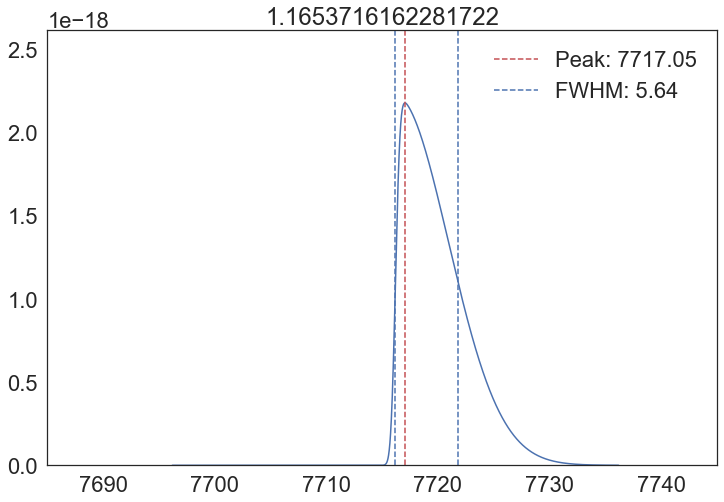

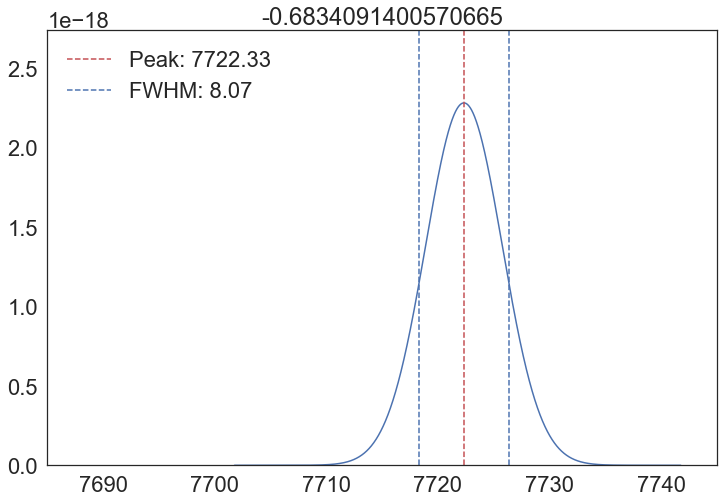

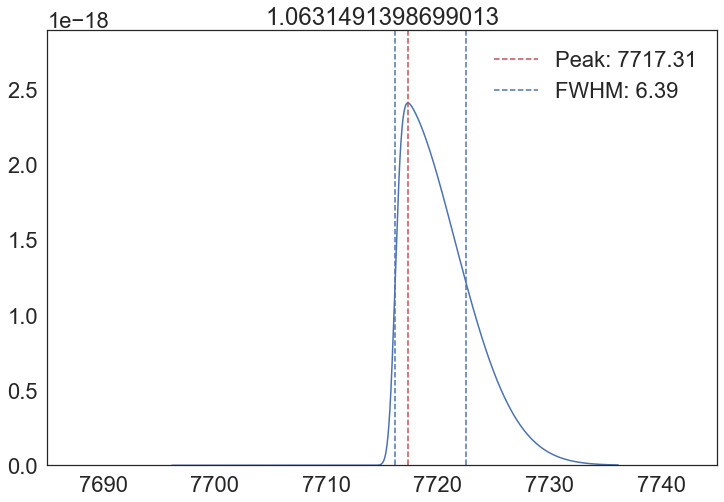

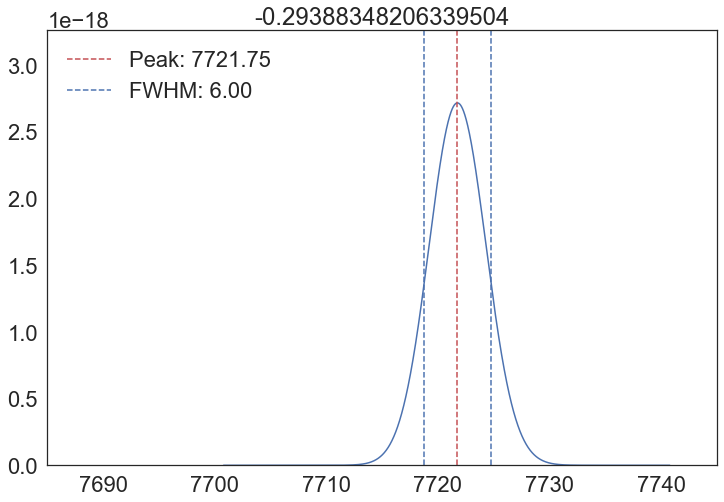

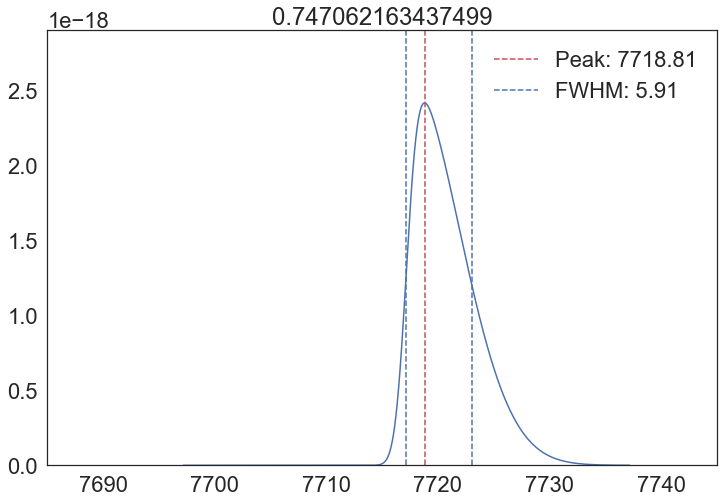

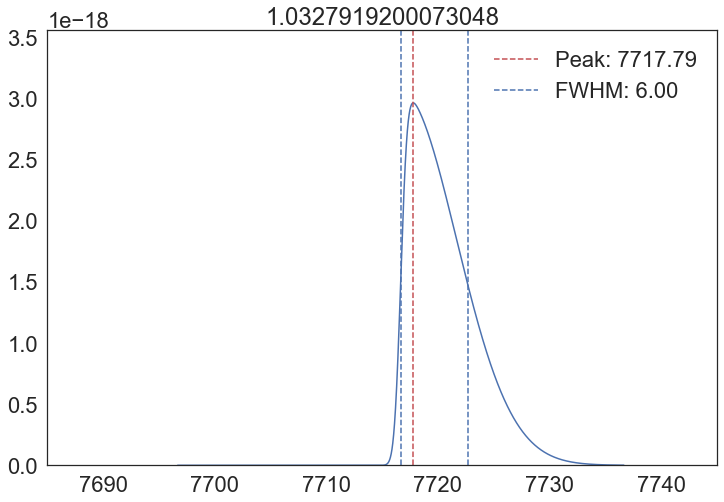

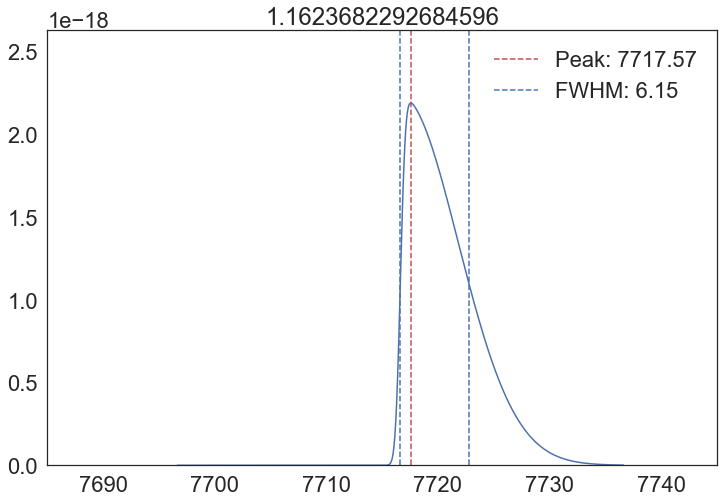

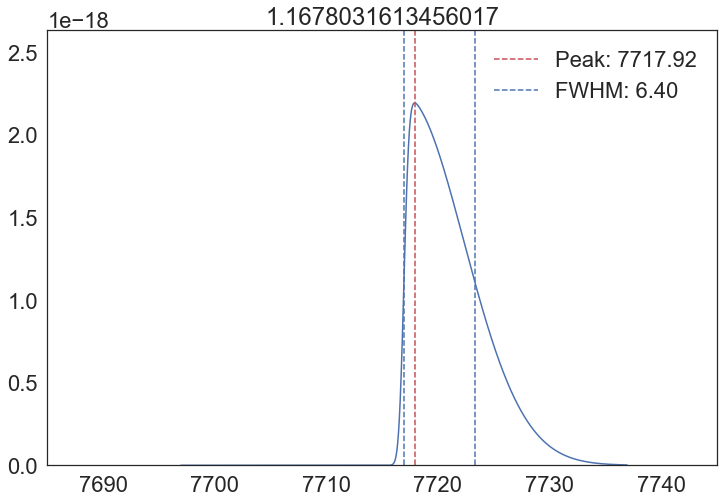

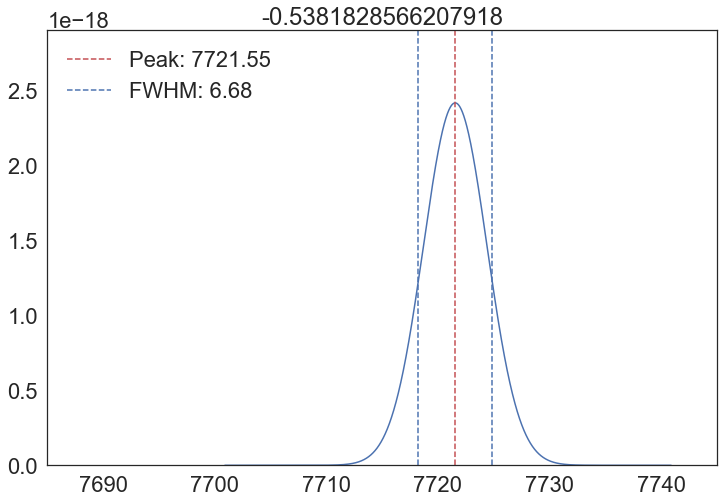

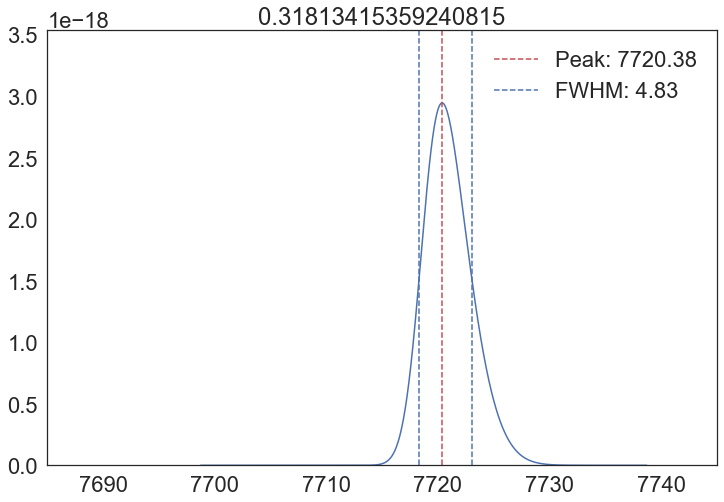

Finished
(array([207.5293761 , 172.1577272 , 220.79728498, ..., 218.81604309,
       237.4901325 , 189.62408659]), array([5.35165171, 5.35187883, 5.35008599, ..., 5.35117726, 5.35068599,
       5.35259721]))


In [26]:
import numpy as np
All_Dist=np.load("Alldist_25JulTest.npy",allow_pickle=True)
All_newFWHM={}
All_newzlya={}
for gal in All_Dist[:]:
    id=gal[2]["ID"]
    print(id)
    loc=np.array(gal[0]["loc"])
    fwhm=np.array(gal[0]["fwhm"])
    g=np.array(gal[0]["g"])
    amp=np.array(gal[0]["amp"])
    new_fwhm=FWHM_literature(amp,loc,fwhm,g,showPlots=True)
    print(new_fwhm)
    All_newFWHM[id]=new_fwhm[0]
    All_newzlya[id]=new_fwhm[1]


#np.save("Posterior_FWHM.npy",All_newFWHM)
#np.save("Posterior_zlya.npy",All_newzlya)

In [ ]:
from scipy.stats import linregress
from scipy.optimize import curve_fit

Catalog=ascii.read("../A-Catalogs/Binospec-Candels.cat")
Removed=["Stark11_35_22248"]

IDs=[]
mask=[]
for gal in All_Dist:
    if gal[2]["ID"] not in Removed:
        mask.append(True)
        IDs.append(gal[2]["ID"])
    else:  
        mask.append(False)

new_medz=np.array([np.nanmedian(i) for i in np.array(All_newzlya)[mask]])
new_medFWHM=np.array([np.nanmedian(i) for i in np.array(All_newFWHM)[mask]])
new_stdFWHM=np.array([np.nanstd(i) for i in np.array(All_newFWHM)[mask]])
old_LyaFWHM,old_zlya=[],[]
i=0

for i,id in enumerate(IDs):
    for gal in Catalog:
        if gal["id_charlotte"]==id:

            gal["LyaFWHM"]=new_medFWHM[i]
            gal["dLyaFWHM"]=new_stdFWHM[i]
            gal["z"]=new_medz[i]
            old_LyaFWHM.append(gal["LyaFWHM"])
            old_zlya.append(gal["z"])
            i=i+1

Catalog.write("../A-Catalogs/Binospec-Candels.cat",format="ascii",overwrite=True)




Finished
Finished
Finished
Finished
Finished
Finished
Finished
Finished
Finished
Finished
Finished
Finished
Finished
Finished
Finished
Finished
Finished
Finished
Finished
Finished
Finished
Finished
Finished
Finished
Finished
Finished
Finished
Finished
Finished
Finished
Finished
Finished
Finished
Finished
Finished
Finished
Finished
Finished
Finished
Finished
Finished
Finished
Finished
Finished
Finished
Finished
Finished
Finished
Finished
Finished
Finished
Finished
Finished
Finished
Finished
Finished
Finished
Finished
Finished
Finished
Finished
Finished
Finished
Finished
Finished


In [293]:
from scipy.stats import linregress
from scipy.optimize import curve_fit

Catalog=ascii.read("../A-Catalogs/Binospec-Candels.cat")
Removed=["Stark11_35_22248"]

IDs=[]
mask=[]
for gal in All_Dist:
    if gal[2]["ID"] not in Removed:
        mask.append(True)
        IDs.append(gal[2]["ID"])
    else:  
        mask.append(False)

new_medz=np.array([np.nanmedian(i) for i in np.array(All_newzlya)[mask]])
new_medFWHM=np.array([np.nanmedian(i) for i in np.array(All_newFWHM)[mask]])
new_stdFWHM=np.array([np.nanstd(i) for i in np.array(All_newFWHM)[mask]])
old_LyaFWHM,old_zlya=[],[]
i=0

for i,id in enumerate(IDs):
    for gal in Catalog:
        if gal["id_charlotte"]==id:

            gal["LyaFWHM"]=new_medFWHM[i]
            gal["dLyaFWHM"]=new_stdFWHM[i]
            gal["z"]=new_medz[i]
            old_LyaFWHM.append(gal["LyaFWHM"])
            old_zlya.append(gal["z"])
            i=i+1

Catalog.write("../A-Catalogs/Binospec-Candels.cat",format="ascii",overwrite=True)




In [1]:


plt.scatter(old_zlya,new_medz)
plt.plot([5,7],[5,7],color="black",ls="--")
plt.xlabel("z old")
plt.ylabel("z new")
plt.show()

plt.scatter(old_LyaFWHM, new_medFWHM)
plt.plot([0,1000],[0,1000],color="black",ls="--")


def linear_func(x, a, b):
    return a * x + b

popt, pcov = curve_fit(linear_func, old_LyaFWHM, new_medFWHM)
slope, intercept = popt

plt.plot(old_LyaFWHM, linear_func(np.array(old_LyaFWHM), *popt), 'r', label=f'fit: y={slope:.2f}x+{intercept:.2f}')
print(popt)

plt.legend()
plt.xlabel("FWHM old")
plt.ylabel("FWHM new")
plt.show()



#plt.scatter(old_zlya,All_newzlya)
#plt.show()
#plt.scatter(old_LyaFWHM,All_newFWHM)
#plt.show()


NameError: name 'plt' is not defined

In [268]:
mask = ~np.isnan(old_zlya) & ~np.isnan(new_medz)
old_zlya = np.array(old_zlya)[mask]
new_medz = np.array(new_medz)[mask]
print(mask)

[ True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True]


In [270]:
IDs[4]

'Stark11_35_22248'

In [ ]:
def recover_param(data,key): #MEDIANS OR MAXs
    ml=[]
    mcmc=[]
    for d in data:
        ml.append([d[1][key],np.nan])
        try:
            val,bin = np.histogram(d[0][key],bins=100)
            #plt.plot(bin[:-1],val)
            #plt.axvline(x=MedianHist(val,bin),color="gray",label="median")
            index = np.where(val == max(val)) #Put median
            #plt.axvline(x=bin[index[0][0]],color="red",label="max")
            #plt.legend()
            #plt.show()
            
            mcmc.append(MedianHist(val,bin))
        except:
            mcmc.append([np.nan,np.nan])
        '''
        Make something for gaussian PDFs, and non gaussian PDfs
        fit a gaussian to see if it is gaussian or it isnt
        '''
        
    return np.array(ml),np.array(mcmc)




ml_flux,mcmc_flux=recover_param(All_Dist,"amp")
ml_flux=onlyCentralValue(ml_flux)
flux_err=only1sigma(mcmc_flux)
mcmc_flux=onlyCentralValue(mcmc_flux)



plt.hist(np.log10(mcmc_flux),bins=18,range=[-18,-16],**kws)
plt.xlabel(r"log$_{10}$Flux$_{Lya}$ [erg/s/cm2]",size=20)
plt.tight_layout()
#plt.savefig('plots/profiles/Transparent/Fluxes.png',dpi=200,transparent=True)
plt.show()

plt.hist(np.log10(flux_err),bins=18,**kws)
plt.xlabel(r"log$_{10}$Flux$_{Lya}$ [erg/s/cm2]",size=20)
plt.tight_layout()
#plt.savefig('plots/profiles/Transparent/Fluxes.png',dpi=200,transparent=True)
plt.show()


In [ ]:
mcmc_flux

In [ ]:
def finderParam(mcmc,ml):
    p=[]
    for i in range(0,len(mcmc)):
        if np.isnan(mcmc[i])==False:
            p.append(mcmc[i])
        elif np.isnan(ml[i])==False:
            p.append(ml[i])
        else:
            p.append(np.nan)
    return np.array(p)

def finderErr(mcmc,flux):
    p=[]
    for i in range(0,len(mcmc)):
        if np.isnan(mcmc[i])==False:
            p.append(mcmc[i])
        else:
            p.append(flux[i]*0.1)
    return np.array(p)


f=finderParam(mcmc_flux,ml_flux)
peaks=finderParam(mcmc_peak,ml_peak)
fwhm=finderParam(mcmc_fwhm,ml_fwhm)
gs=finderParam(gs_mcmc,gs_ml)

fluxErr=finderErr(flux_err,f)

In [ ]:
All_Dist[0]

In [ ]:
from astropy.io import ascii
from astropy.table import Table





Id=[i[2]["ID"] for i in All_Dist]

#z=redshift(peaks)
z=[]
for gal in All_Dist:
    try:
        z.append(redshift(gal[0]["peak"]))
    except:
        z.append(redshift(gal[1]["peak"])) 

Lyaflux=np.log10(f)
LyaErr=np.log10(fluxErr)
LyaFWHM=angstromTokms(peaks,fwhm)
Skewness=skewness_func(gs)

print(len(Id))
print(len(z))
print(len(Lyaflux))
print(len(LyaFWHM))
print(len(Skewness))

data = Table()
data['ID'] = Id
data['z'] = z
data["LyaFlux"] =   Lyaflux
data["LyaErr"]  =   LyaErr
data['LyaFWHM'] =   LyaFWHM
data["Skewness"]    =   Skewness
#ascii.write(data, '../catalogs/BLAS_data.cat', overwrite=True) 




In [ ]:
LyaErr

In [ ]:
(10**-17.56298581)/(10**-16.812806564151835)

In [ ]:
def vOffset(zLya,zSys):
    c=299792.458 #km/s
    offset=c*((zLya-zSys)/(1+zSys))
    return offset

In [ ]:
vOffset(6.814354300459611,6.807177942453674)

In [ ]:
for gal in Catalog:
    if gal["id_charlotte"]=="z7_GND_8358":
        print(gal["zsys"])

In [ ]:
Catalog[Catalog["id_charlotte"]=="z7_GND_8358"]["z"]

In [ ]:
All_Dist[0][0]["peak"]

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

g=np.arange(-50,50,1)
delta=g/(np.sqrt(1+g**2))
skewness = ((4-np.pi)/2)  * (delta*np.sqrt(2/np.pi)**3)/(1-2*delta**2/np.pi)**(3/2)
print(delta)
print(skewness)
plt.axvline(x=15)
plt.plot(g,skewness)
plt.plot(g,delta)
plt.ylabel("Skewness",size=15)
plt.xlabel(r"g",size=15)
plt.show()
#plt.plot(g,delta)



In [ ]:
print(len(np.arange(6760.0,6760.0+5631*0.620000004768,0.620000004768)))

In [ ]:
mask1=[True,False,False,True]
mask2=[False,True,True,True]

fullmask= [x[0] and x[1] for x in zip(mask1,mask2)]
print(fullmask)

In [ ]:
def skewed_gaussian(x,g) :
    """Gaussian"""
    fw_param=(5/(2*np.sqrt(2*np.log(2))))
    return (1/(fw_param*np.sqrt(2*np.pi))) * np.exp( -0.5 * (x)**2 / fw_param**2)* (1+scispe.erf( g*(x)/(fw_param*np.sqrt(2))))

xx=np.linspace(-15,15,100)
gg=[0,2,5,10,15]
counter=0
print(gg)
for gs in gg:
    plt.plot(xx,skewed_gaussian(xx,gs)/max(skewed_gaussian(xx,gs)),lw=5,alpha=0.4,label=r"$\alpha$="+str(gs))
    counter+=1
plt.xlim(-7,7)
plt.legend()
plt.ylabel("Normalized")
plt.show()


g=np.arange(0,15,0.01)
delta=g/(np.sqrt(1+g**2))
skewness = ((4-np.pi)/2)  * (delta*np.sqrt(2/np.pi)**3)/(1-2*delta**2/np.pi)**(3/2)
print(delta)
print(skewness)
#plt.axvline(x=15)
plt.plot(g,skewness,lw=5,alpha=0.4)
#plt.plot(g,delta,lw=5,alpha=0.4)
plt.ylabel("Skewness",size=15)
plt.xlabel(r"$\alpha$",size=15)
plt.show()




plt.rcParams["figure.figsize"] = (3,3)
sns.set_theme(style="white",font_scale = 1.2)
xx=np.linspace(-15,15,1000)
g=np.array([0,1,2,5,15])
delta=g/(np.sqrt(1+g**2))
skewness = ((4-np.pi)/2)  * (delta*np.sqrt(2/np.pi)**3)/(1-2*delta**2/np.pi)**(3/2)
print(skewness)
counter=0
print(gg)
for gs in g:
    if counter==0:
        k="Skewness"
    else:
        k=""
    plt.plot(xx,skewed_gaussian(xx,gs)/max(skewed_gaussian(xx,gs)),lw=5,alpha=0.4,label=k+" = "+str(np.round(skewness[counter],1)))
    counter+=1
plt.xlim(-7,7)
plt.legend()
plt.ylabel("Normalized")
plt.xticks(color='w')
plt.tight_layout()
plt.savefig('../data/large_files/plots/profiles/Transparent/fwhm.png',dpi=200,transparent=True)
plt.show()



In [ ]:
a=[1,1,1,1]
b=[]
for i in range(0,11):
    b.append(a)
print(np.shape(b))

In [ ]:
plt.rcParams["figure.figsize"] = (3,3)
sns.set_theme(style="white",font_scale = 1.2)
xx=np.linspace(-15,15,1000)
g=np.array([15])
delta=g/(np.sqrt(1+g**2))
skewness = ((4-np.pi)/2)  * (delta*np.sqrt(2/np.pi)**3)/(1-2*delta**2/np.pi)**(3/2)
print(skewness)
counter=0
print(gg)
for gs in g:
    if counter==0:
        k="Skewness"
    else:
        k=""
    plt.plot(xx,skewed_gaussian(xx,gs)/max(skewed_gaussian(xx,gs)),lw=5,alpha=0.4,label=k+" = "+str(np.round(skewness[counter],1)))
    counter+=1
plt.xlim(-7,7)
#plt.legend()
plt.xlabel("Skewness = 1",size=30)
plt.yticks(color='#F2E4EF')
plt.xticks(color='#F2E4EF')
plt.tight_layout()
plt.savefig('../data/large_files/plots/profiles/Transparent/example2.png',dpi=200,transparent=True)
plt.show()

In [ ]:
data_dir = 'data/'
fname_data = np.sort(glob.glob(data_dir+"large_files/Reduced_Data/*/2D/noiseCorrected/*.fits")) #read data
fname_data = [i for i in fname_data if "3DHST" not in i and "f_" not in i] #takes only LAEs
PossibleLines=[]
Specs=[]
for data in fname_data[:]:
    HDU = fits.open(data)
    flux=HDU[0]
    error=HDU[1]
    Inventory(Spectra(flux,SpectraData(flux,error))).addSpectra(Specs,flux)  #This is the class that has many functions to manipulate the data


In [ ]:
Ids=[s.Data.header["SLITOBJ"] for s in Specs]
np.save("Photometry/Catalogs/Bino_IDs.npy",Ids)
